## Loading and initialize the data

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import pickle
import numpy as np
import sys
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
figure = 0

def OneHot(labels):
    labOneHot = np.zeros(shape=(10,len(labels)))
    for i, label in enumerate(labels):
        labOneHot[label,i] = 1
    return labOneHot

def LoadBatch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    X = dict[b'data'].T
    y = dict[b'labels']
    Y = OneHot(y) 
    return X, Y, y

def Normalize(X, inX):
    mean_X = inX.mean(axis=1).reshape(inX.shape[0], 1)
    std_X = inX.std(axis=1).reshape(inX.shape[0], 1)
    norm = (X - mean_X) / std_X
    return norm

def softmax(x):
    """ Standard definition of the softmax function """
    return np.exp(x) / np.sum(np.exp(x), axis=0)


#### Loading the datasets and normalizing 

In [12]:
#Loading the data
X1, Y1, y1 = LoadBatch('cifar-10-batches-py/data_batch_1')
X2, Y2, y2 = LoadBatch('cifar-10-batches-py/data_batch_2')
X3, Y3, y3 = LoadBatch('cifar-10-batches-py/data_batch_3')
X4, Y4, y4 = LoadBatch('cifar-10-batches-py/data_batch_4')
X5, Y5, y5 = LoadBatch('cifar-10-batches-py/data_batch_5')

#Initialize test set
testX, testY, test_y = LoadBatch('cifar-10-batches-py/test_batch')

In [13]:
#Stacking batches
X = np.hstack((X1, X2, X3, X4, X5))
Y = np.hstack((Y1, Y2, Y3, Y4, Y5))
y = y1 + y2 + y3 + y4 + y5

#Initialize validation set
np.random.seed(0)
vIndex = np.random.choice(range(X.shape[1]), 5000, replace=False)
validX = X[:,vIndex]
validY = Y[:,vIndex]
valid_y = [y[i] for i in vIndex]

#Initialize train set
trainX = np.delete(X, vIndex, 1)
trianY = np.delete(Y, vIndex, 1)
train_y = [y[i] for i in range(X.shape[1]) if i not in vIndex]

#Normalizing the datasets
scaleX = trainX
trainX = Normalize(trainX, scaleX)
validX = Normalize(validX, scaleX)
testX = Normalize(testX, scaleX)

#### Initialize Weights

In [14]:
def initializeValues(inDim, hiddenDim, outDim, he=True, rng=0, std=0.01): 
    
    np.random.seed(rng)
    k = len(hiddenDim)+1
    gamma = [0]*(k-1)
    beta = [0]*(k-1)
    W = [0]*k
    b = [0]*k
    m = [inDim]+hiddenDim+[outDim]
     
    for i in range(k):
        s = np.sqrt(2/m[i]) if he else std
        W[i] = np.random.normal(size=(m[i+1], m[i]), loc=0, scale=s)
        b[i] = np.zeros((m[i+1], 1))
        if i<(k-1):
            gamma[i] = np.ones((m[i+1], 1))
            beta[i] = np.zeros((m[i+1], 1))
        
    return W, b, gamma, beta

## Forward pass

In [15]:
def BatchNormalize(S, me, v, MeV):
    if MeV:
        me = S.mean(axis=1).reshape(-1,1)
        v = S.var(axis=1).reshape(-1,1)
    S_hat = (S-me)/(np.sqrt(v+1e-15))
    return S_hat, me, v
    
def EvaluateClassifier(X, W, b, gamma=None, beta=None, me=None, v=None, BN=False):
    
    k = np.size(W,0)
    H = [X.copy()]+[0]*(k-1)
    S = [0]*(k-1)
    S_hat = [0]*(k-1)
    
    if BN:
        if me is None and v is None:
            MeV = True
            me = [0]*(k-1)
            v = [0]*(k-1)
        else:
            MeV = False
    
    for i in range(k-1):
        S[i] = W[i]@H[i]+b[i]
        if BN:
            S_hat[i], me[i], v[i] = BatchNormalize(S[i], me[i], v[i], MeV)
            S_BN = S_hat[i]*gamma[i]+beta[i]
            S_BN[S_BN<0] = 0
            H[i+1] = S_BN
        else:
            S[i][S[i]<0] = 0
            H[i+1] = S[i]
            
    P = softmax(W[k-1]@H[k-1]+b[k-1])
    
    if BN:
        if MeV:
            return P, S_hat, S, H[1:], me, v
        else:
            return P, S_hat, S, H[1:]
    else:
        return P, H[1:]

#### Help functions

In [16]:
def ComputeAccuracy(X, y, W, b, BN, gamma=None, beta=None, me=None, v=None):
    
    if BN:
        if me is None and v is None:
            P, S_hat, S, H, me, v = EvaluateClassifier(X, W, b, gamma, beta, BN=True)
        else:
            P, S_hat, S, H = EvaluateClassifier(X, W, b, gamma, beta, me, v, BN=True)
    else:
        P, H = EvaluateClassifier(X, W, b)
    
    accuracy = np.mean(y==np.argmax(P, 0))
    
    return accuracy

In [17]:
def ComputeCost(X, Y, lamd, W, b, BN, gamma=None, beta=None, me=None,v=None):
    
    if BN:
        if me is None and v is None:
            P, S_hat, S, H, me, v = EvaluateClassifier(X, W, b, gamma, beta, BN=True)
        else:
            P, S_hat, S, H = EvaluateClassifier(X, W, b, gamma, beta, me, v, BN=True)
    else:
        P, H = EvaluateClassifier(X, W, b)
    
    l = -np.log((Y*P).sum(axis=0))/X.shape[1]
    J = sum(l)
    
    for Wi in W:
        J += lamd*((Wi**2).sum())
    
    return J

In [18]:
def Plot(s_val, cycles=None):
    _, axes = plt.subplots(1, 2, figsize=(18,6))
    
    for v, ax in zip(['C', 'A'], axes.flatten()):
        
        epochTrain = np.argmin(s_val['train'+v]) if v=='C' else np.argmax(s_val['train'+v])
        train = np.round(s_val['train'+v][epochTrain], 4)
        
        labT = 'Train: '+str(train)
        ax.plot(s_val['step'], s_val['train'+v], label=labT)
        
        epochValid = np.argmin(s_val['valid' + v]) if v=='C' else np.argmax(s_val['valid'+v])
        valid = np.round(s_val['valid' + v][epochValid], 4)
            
        labV = 'Validation: '+str(valid)
        ax.plot(s_val['step'], s_val['valid' + v], label=labV)
        
        ax.grid(True)
        ax.set_xlabel("Update step")
        ax.set_ylabel('Accuracy' if v=='A' else 'Loss')
        ax.legend()

## Backward Pass

In [19]:
def BackBN(G, S, me, v):
    n = S.shape[1]
    G1 = G*(((v+1e-15)**(-0.5))@np.ones((1,n)))
    G2 = G*(((v+1e-15)**(-1.5))@np.ones((1,n)))
    D = S-me@np.ones((1,n))
    c = (G2*D)@np.ones((n,1))
    
    return G1-(G1@np.ones((n,1)))/n-D*(c@np.ones((1,n)))/n

def ComputeGradients(X, Y, P, H, W, b, lamd, S_hat=None, S=None, gamma=None, beta=None, me=None, v=None, BN=False):

    k = np.size(W,0)
    n = X.shape[1]
    grad_W = [0]*k
    grad_b = [0]*k
    H = [X.copy()]+H
    
    #Last layer
    G = P-Y
    grad_W[k-1] = (G@H[k-1].T)/n+2*lamd*W[k-1]
    grad_b[k-1] = (G@np.ones((n,1)))/n
    G = W[k-1].T@G
    G = G*(H[k-1]>0)
    
    if BN:
        grad_gamma = [0]*(k-1)
        grad_beta = [0]*(k-1)
    
    for i in range(k-2, -1, -1):
        
        if BN:
            grad_gamma[i] = ((G*S_hat[i])@np.ones((n,1)))/n
            grad_beta[i] = (G@np.ones((n,1)))/n
            G = G*(gamma[i]@np.ones((1,n)))
            G = BackBN(G, S[i], me[i], v[i])
        
        grad_W[i] = (G@H[i].T)/n+2*lamd*W[i]
        grad_b[i] = (G@np.ones((n,1)))/n
        
        if i>0:
            G = W[i].T@G
            G = G*(H[i]>0)
        
    if BN:
        return grad_W, grad_b, grad_gamma, grad_beta
    else:
        return grad_W, grad_b

In [20]:
def ComputeGradsNum(X, Y, lamd, W, gamma=None, beta=None, me=None, v=None,BN=False, h=0.000001):
    """ Converted from matlab code """

    grad_W = [Wi.copy() for Wi in W]
    grad_b = [bi.copy() for bi in b]
    c = ComputeCost(X, Y, lamd, W, b, BN, gamma, beta, me, v)
    k = len(W)
    
    if BN:
        grad_gamma = [gammaI.copy() for gammaI in gamma]
        grad_beta = [betaI.copy() for betaI in beta]
        
    for l in range(k):
        
        for i in range(b[l].shape[0]):
            b_try = [b_l.copy() for b_l in b]
            b_try[l][i,0] += h
            c2 = ComputeCost(X, Y, lamd, W, b_try, BN, gamma, beta, me, v)
            grad_b[l][i,0] = (c2-c)/h
        
        for i in range(W[l].shape[0]):
            for j in range(W[l].shape[1]):
                W_try = [W_l.copy() for W_l in W]
                W_try[l][i,j] += h
                c2 = ComputeCost(X, Y, lamd, W_try, b, BN, gamma, beta, me, v)
                grad_W[l][i,j] = (c2-c)/h
                
        if l<(k-1) and BN:
  
            for i in range(gamma[l].shape[0]):
                gamma_try = [gammai.copy() for gammai in gamma]
                gamma_try[l][i,0] += h
                c2 = ComputeCost(X, Y, lamd, W, b, BN, gamma_try, beta, me, v)
                grad_gamma[l][i,0] = (c2-c)/h
            
            for i in range(beta[l].shape[0]):
                beta_try = [beta_l.copy() for beta_l in beta]
                beta_try[l][i,0] += h
                c2 = ComputeCost(X, Y, lamd, W, b, BN, gamma, beta_try, me, v)
                grad_beta[l][i,0] = (c2-c)/h
    
    if BN:
        return grad_W, grad_b, grad_gamma, grad_beta
    else:
        return grad_W, grad_b

In [21]:
def MiniBatchGD(X, Y, y, GDparams, lamd, W, b,  validX, validY, valid_y, gamma=None, beta=None, BN=False):
    
    n = X.shape[1]
    grad_W = [Wi.copy() for Wi in W]
    grad_b = [bi.copy() for bi in b]
    step_s = GDparams['step_s']
    n_batch = GDparams['n_batch']
    cycles = GDparams['cycles']
    batches = {}
    Xbef = X.copy()
    Ybef = Y.copy()
    y_bef = y.copy()
    eta_min = 1e-5
    eta_max = 1e-1
    alpha=0.9
    ind = 0
    
    if BN:
        grad_gamma = [gammaI.copy() for gammaI in gamma]
        grad_beta = [betaI.copy() for betaI in beta]
    
    s_val = {'step':[-1],
             'trainA':[ComputeAccuracy(X, y, W, b, BN, gamma, beta)],
             'trainC':[ComputeCost(X, Y, lamd, W, b, BN, gamma, beta)],
             'validA':[ComputeAccuracy(validX, valid_y, W, b, BN, gamma, beta)],
             'validC':[ComputeCost(validX, validY, lamd, W, b, BN, gamma, beta)]}
    
    for j in range(n//n_batch):            
        j_start = j*n_batch
        j_end = (j+1)*n_batch
        inds = range(j_start, j_end)
        batches[j] = (X[:,inds], Y[:,inds], [y[index] for index in inds])
    
    for cycle in range(cycles):
        
        for t in range(2*cycle*step_s, 2*(cycle+1)*step_s):
            X_b, Y_b, y_b = batches[ind]
            
            if t>= 2*cycle*step_s and t<(2*cycle+1)*step_s:
                eta = eta_min+(t-2*cycle*step_s)/step_s*(eta_max-eta_min)
            elif t>=(2*cycle+1)*step_s and t<2*(cycle+1)*step_s:
                eta = eta_max-(t-(2*cycle+1)*step_s)/step_s*(eta_max-eta_min)
            
            if BN:
                P, S_hat, S, H, me, v = EvaluateClassifier(X_b, W, b, gamma, beta, BN=True)
            else:
                P, H = EvaluateClassifier(X_b, W, b)            

            if cycle==0 and t==0 and BN:
                mAv = me
                vAv = v
            elif BN:
                mAv = [alpha*mAv[l]+(1-alpha)*me[l] for l in range(len(me))]
                vAv = [alpha*vAv[l]+(1-alpha)*v[l] for l in range(len(v))]
            else:
                mAv = None
                vAv = None

            if BN:
                grad_W, grad_b, grad_gamma, grad_beta = \
                    ComputeGradients(X_b, Y_b, P, H, W, b, lamd, S_hat, S, gamma, beta, me, v, BN=True)
                gamma = [gamma[l]-eta*grad_gamma[l] for l in range(len(gamma))]
                beta = [beta[l]-eta*grad_beta[l] for l in range(len(beta))]
            else:
                grad_W, grad_b = ComputeGradients(X_b, Y_b, P, H, W, b, lamd)
    
            W = [W[i]-eta*grad_W[i] for i in range(len(W))]
            b = [b[i]-eta*grad_b[i] for i in range(len(b))]
            ind += 1
            
            if ind > n//n_batch-1:
                batches = {}
                ind = 0
            
                s_val['trainA'].append(ComputeAccuracy(X, y, W, b, BN, gamma, beta, mAv, vAv))
                s_val['trainC'].append(ComputeCost(X, Y, lamd, W, b, BN, gamma, beta, mAv, vAv))
                s_val['validA'].append(ComputeAccuracy(validX, valid_y, W, b, BN, gamma, beta, mAv, vAv))
                s_val['validC'].append(ComputeCost(validX, validY, lamd, W, b, BN, gamma, beta, mAv, vAv))
                s_val['step'].append(t+1)
                
                np.random.seed(t)
                rand = np.random.permutation(n)
                X = Xbef[:,rand]
                Y = Ybef[:,rand]
                y = [y_bef[i] for i in rand]
                
                for j in range(n//n_batch):            
                    j_start = j*n_batch
                    j_end = (j+1)*n_batch
                    inds = range(j_start, j_end)
                    batches[j] = (X[:,inds], Y[:,inds], [y[index] for index in inds])
                    
                msg = "Step "+str(t+1)+'/'+str(2*cycles*step_s)+" | loss="+str(s_val['trainC'][-1])+\
                " | accuracy="+str(s_val['trainA'][-1])+"\r"
                sys.stdout.write(msg)
        
    if BN:
        return W, b, gamma, beta, mAv, vAv, s_val
    else:
        return W, b, s_val

## Exercise 1 k-layer network

In [22]:
lamd = 0
X = trainX[0:20,0:5]
Y = trianY[:,0:5]
inDim = X.shape[0]
outDim = Y.shape[0]

#### Error for 2-layers

In [23]:
hiddenDim = [50]
W, b, gamma, beta = initializeValues(inDim, hiddenDim, outDim)

ngrad_W, ngrad_b = ComputeGradsNum(X, Y, lamd, W, b)

P, H = EvaluateClassifier(X, W, b)
grad_W, grad_b = ComputeGradients(X, Y, P, H, W, b, lamd)

print("Maxium absolute error for W:")
print([np.max(np.abs(grad_W[i]-ngrad_W[i])) for i in range(len(grad_W))])

print("Maxium absolute error for b:")
print([np.max(np.abs(grad_b[i]-ngrad_b[i])) for i in range(len(grad_b))])

Maxium absolute error for W:
[2.958827793539398e-08, 1.0067522733248069e-06]
Maxium absolute error for b:
[2.087267415504246e-08, 8.114379418389106e-08]


#### Error for 3-layers

In [24]:
hiddenDim = [50, 50]
W, b, gamma, beta = initializeValues(inDim, hiddenDim, outDim)

ngrad_W, ngrad_b = ComputeGradsNum(X, Y, lamd, W, b)

P, H = EvaluateClassifier(X, W, b)
grad_W, grad_b = ComputeGradients(X, Y, P, H, W, b, lamd)

print("Maxium absolute error for W:")
print([np.max(np.abs(grad_W[i]-ngrad_W[i])) for i in range(len(grad_W))])

print("Maxium absolute error for b:")
print([np.max(np.abs(grad_b[i]-ngrad_b[i])) for i in range(len(grad_b))])

Maxium absolute error for W:
[2.1646908321404368e-08, 3.6173378725745664e-07, 6.483375731280994e-07]
Maxium absolute error for b:
[1.8061764095640698e-08, 2.724076016971319e-08, 6.188608364654513e-08]


#### Error for 4-layers

In [25]:
hiddenDim = [50, 50, 50]
W, b, gamma, beta = initializeValues(inDim, hiddenDim, outDim)

ngrad_W, ngrad_b = ComputeGradsNum(X, Y, lamd, W, b)

P, H = EvaluateClassifier(X, W, b)
grad_W, grad_b = ComputeGradients(X, Y, P, H, W, b, lamd)

print("Maxium absolute error for W:")
print([np.max(np.abs(grad_W[i]-ngrad_W[i])) for i in range(len(grad_W))])

print("Maxium absolute error for b:")
print([np.max(np.abs(grad_b[i]-ngrad_b[i])) for i in range(len(grad_b))])

Maxium absolute error for W:
[2.4083921829065602e-08, 6.53413739781783e-07, 2.176787635074784e-07, 5.89495092462311e-07]
Maxium absolute error for b:
[1.6851190109967717e-08, 3.018915850638848e-08, 3.067817076415902e-08, 5.3313271963784103e-08]


## Exercise 2 training k-layer network

In [26]:
GDparams = {'step_s':int(5*45000/100), 'n_batch':100, 'cycles':2}
inDim = trainX.shape[0]
outDim = trianY.shape[0]
lamd = 0.005

### 2-Layer no BN

In [28]:
hiddenDim = [50]
W, b, gamma, beta = initializeValues(inDim, hiddenDim, outDim, he=True)
W, b, s_val = MiniBatchGD(trainX, trianY, train_y, GDparams, lamd, W, b, validX, validY, valid_y)

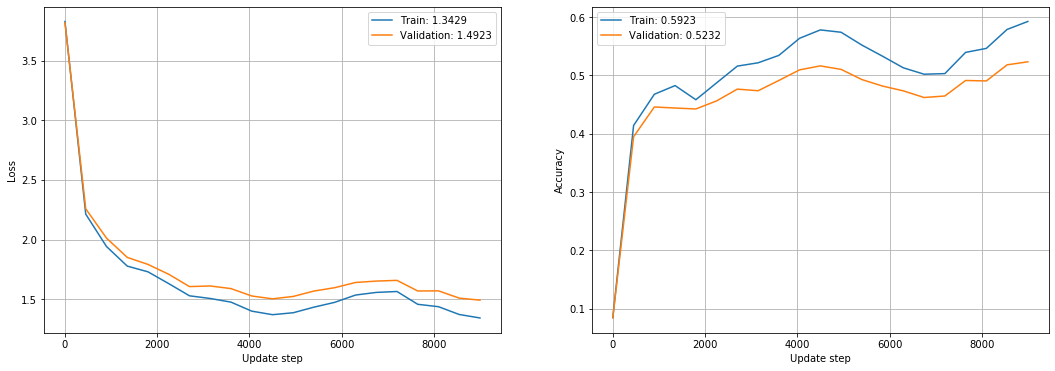

In [29]:
Plot(s_val, cycles=GDparams['cycles'])

### 3-layer no BN

In [27]:
hiddenDim = [50,50]
W, b, gamma, beta = initializeValues(inDim, hiddenDim, outDim, he=True)
W, b, s_val = MiniBatchGD(trainX, trianY, train_y, GDparams, lamd, W, b, validX, validY, valid_y)

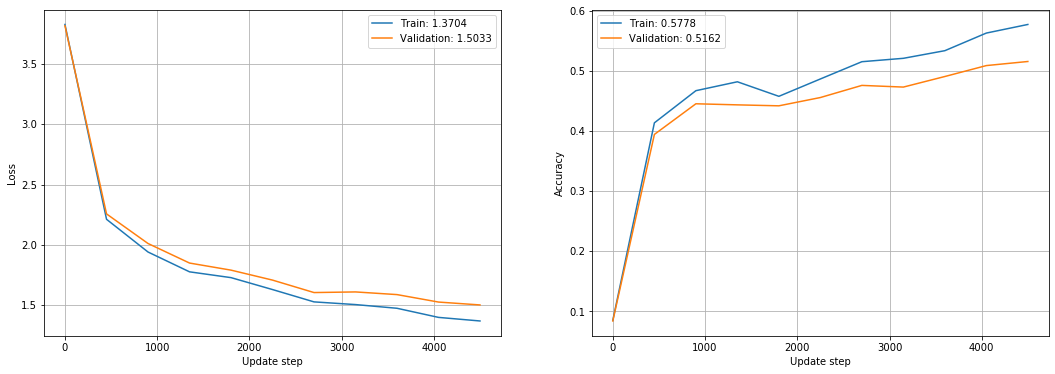

In [753]:
Plot(s_val, cycles=GDparams['cycles'])

### 9-layer no BN

In [30]:
hiddenDim = [50,30,20,20,10,10,10,10]
W, b, gamma, beta = initializeValues(inDim, hiddenDim, outDim, he=True)
W, b, s_val = MiniBatchGD(trainX, trianY, train_y, GDparams, lamd, W, b, validX, validY, valid_y)

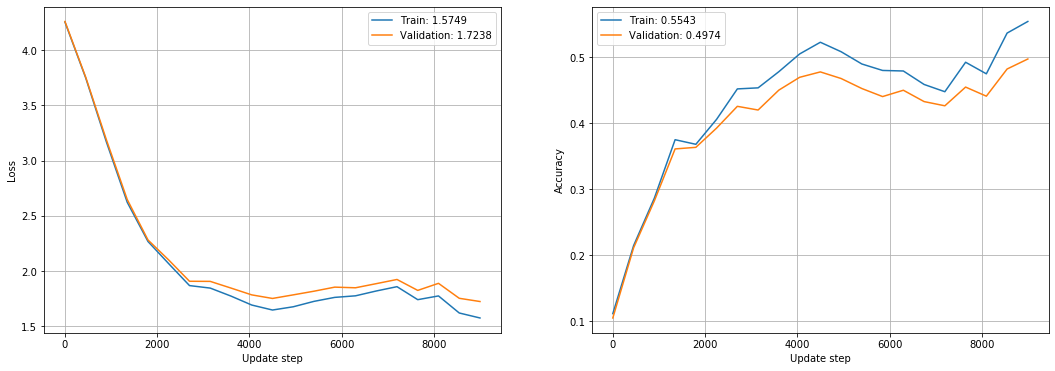

In [31]:
Plot(s_val, cycles=GDparams['cycles'])

## Exercise 3 batch normalization

In [711]:
lamd = 0
X = trainX[0:20,0:5]
Y = trianY[:,0:5]
outDim = Y.shape[0]
inDim = X.shape[0]

In [712]:
hiddenDim = [50]
W, b, gamma, beta = initializeValues(inDim, hiddenDim, outDim)

ngrad_W, ngrad_b, ngrad_gamma, ngrad_beta = ComputeGradsNum(X, Y, lamd, W, gamma, beta, BN=True)
P, S_hat, S, H, me, v = EvaluateClassifier(X, W, b, gamma, beta, BN=True)
grad_W, grad_b, grad_gamma, grad_beta = ComputeGradients(X, Y, P, H, W, b, lamd, S_hat, S, gamma, beta, me, v, BN=True)

print("Maxium absolute error for W:")
print([np.max(np.abs(grad_W[i] - ngrad_W[i])) for i in range(len(grad_W))])

print("Maxium absolute error for b:")
print([np.max(np.abs(grad_b[i] - ngrad_b[i])) for i in range(len(grad_b))])

print("Maxium absolute error for gamma:")
print([np.max(np.abs(grad_gamma[i] - ngrad_gamma[i])) for i in range(len(grad_gamma))])

print("Maxium absolute error for beta:")
print([np.max(np.abs(grad_beta[i] - ngrad_beta[i])) for i in range(len(grad_beta))])

Maxium absolute error for W:
[1.7632922094668046e-06, 6.985593044295246e-08]
Maxium absolute error for b:
[4.440892084622838e-10, 6.637334920567284e-08]
Maxium absolute error for gamma:
[1.543152050587082e-08]
Maxium absolute error for beta:
[2.0525100216661762e-08]


In [713]:
hiddenDim = [50,50]
W, b, gamma, beta = initializeValues(inDim, hiddenDim, outDim)

ngrad_W, ngrad_b, ngrad_gamma, ngrad_beta = ComputeGradsNum(X, Y, lamd, W, gamma, beta, BN=True)
P, S_hat, S, H, me, v = EvaluateClassifier(X, W, b, gamma, beta, BN=True)
grad_W, grad_b, grad_gamma, grad_beta = ComputeGradients(X, Y, P, H, W, b, lamd, S_hat, S, gamma, beta, me, v, BN=True)

print("Maxium absolute error for W:")
print([np.max(np.abs(grad_W[i] - ngrad_W[i])) for i in range(len(grad_W))])

print("Maxium absolute error for b:")
print([np.max(np.abs(grad_b[i] - ngrad_b[i])) for i in range(len(grad_b))])

print("Maxium absolute error for gamma:")
print([np.max(np.abs(grad_gamma[i] - ngrad_gamma[i])) for i in range(len(grad_gamma))])

print("Maxium absolute error for beta:")
print([np.max(np.abs(grad_beta[i] - ngrad_beta[i])) for i in range(len(grad_beta))])

Maxium absolute error for W:
[1.3681938310361463e-06, 3.949921188566019e-07, 8.464443324029958e-08]
Maxium absolute error for b:
[4.4408920985006264e-17, 4.4408920985006264e-17, 7.002452612203669e-08]
Maxium absolute error for gamma:
[5.2237566737500796e-08, 2.7500043169731425e-08]
Maxium absolute error for beta:
[6.062357600297719e-08, 1.3721790592668981e-08]


### 3-layer with BN

In [28]:
GDparams = {'step_s':int(5*45000/100), 'n_batch':100, 'cycles':2}
inDim = trainX.shape[0]
outDim = trianY.shape[0]
lamd = 0.005

In [29]:
hiddenDim = [50,50]
W, b, gamma, beta = initializeValues(inDim, hiddenDim, outDim, he=True)
W, b, gamma, beta, me, v, s_val = MiniBatchGD(trainX, trianY, train_y, GDparams, 
                                              lamd, W, b, validX, validY, valid_y, gamma, beta, BN=True)
               

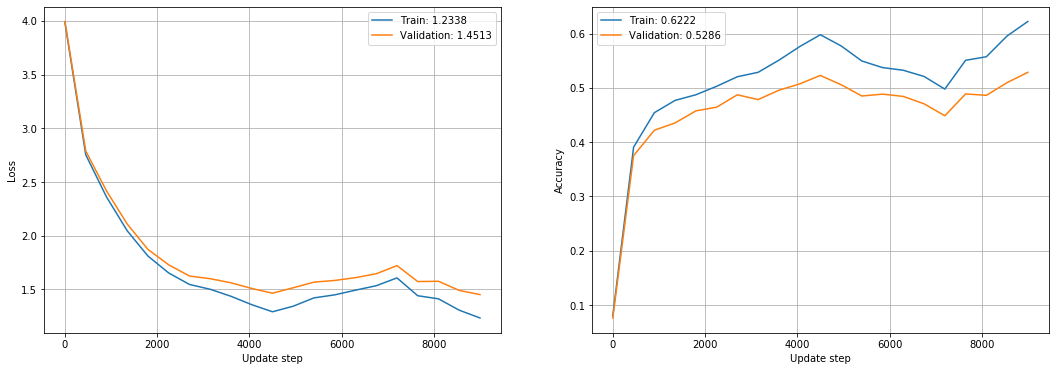

In [30]:
Plot(s_val, cycles=GDparams['cycles'])

## Find a good value for lambda 

In [97]:
GDparams = {'step_s':int(5*45000/100), 'n_batch':100, 'cycles':2}
savedValues = {'lambda':0, 'validA':0, 'trainA':0}
savedMatic = {'values':[]}
inDim = trainX.shape[0]
outDim = trianY.shape[0]
l_min = -5
l_max = -1
times = 10

#### Coarse Random Search

In [98]:
hiddenDim = [50,50]

for i in range(1, times):
    W, b, gamma, beta = initializeValues(inDim, hiddenDim, outDim, he=True)
    np.random.seed(None)
    l = l_min + (l_max - l_min)*np.random.rand(1, 1)
    lamd = 10**l
    W, b, gamma, beta, me, v, s_val = MiniBatchGD(trainX, trianY, train_y, GDparams, 
                                            lamd, W, b, validX, validY, valid_y, gamma, beta, BN=True)
    s = "lambda: {} | validA: {} | trainA: {}".format(lamd, s_val['validA'][-1], s_val['trainA'][-1])
    print(s)

lambda: [[0.00014009]] | validA: 0.5124 | trainA: 0.6485777777777778
lambda: [[0.09390491]] | validA: 0.4868 | trainA: 0.5196222222222222
lambda: [[2.68367881e-05]] | validA: 0.512 | trainA: 0.6427555555555555
lambda: [[3.56364262e-05]] | validA: 0.509 | trainA: 0.6471111111111111
lambda: [[0.00114426]] | validA: 0.5186 | trainA: 0.6494444444444445
lambda: [[1.18084735e-05]] | validA: 0.513 | trainA: 0.6463111111111111
lambda: [[0.02175004]] | validA: 0.5224 | trainA: 0.5668444444444445
lambda: [[0.00303553]] | validA: 0.5266 | trainA: 0.6349777777777778
lambda: [[0.01690297]] | validA: 0.5244 | trainA: 0.580288888888896


#### Fine Search

In [100]:
import math
l_min = math.log10(0.00303553)
l_max = math.log10(0.01690297)
for i in range(1, times):
    W, b, gamma, beta = initializeValues(inDim, hiddenDim, outDim, he=True)
    np.random.seed(None)
    l = l_min + (l_max - l_min)*np.random.rand(1, 1)
    lamd = 10**l
    W, b, gamma, beta, me, v, s_val = MiniBatchGD(trainX, trianY, train_y, GDparams, 
                                            lamd, W, b, validX, validY, valid_y, gamma, beta, BN=True)
    s = "lambda: {} | validA: {} | trainA: {}".format(lamd, s_val['validA'][-1], s_val['trainA'][-1])
    print(s)

lambda: [[0.00742441]] | validA: 0.5284 | trainA: 0.6103111111111111
lambda: [[0.0076666]] | validA: 0.5316 | trainA: 0.6121777777777778
lambda: [[0.00921012]] | validA: 0.527 | trainA: 0.6039777777777777
lambda: [[0.00548111]] | validA: 0.535 | trainA: 0.6187777777777778
lambda: [[0.00949542]] | validA: 0.5332 | trainA: 0.598888888888883
lambda: [[0.01081407]] | validA: 0.5184 | trainA: 0.5968444444444444
lambda: [[0.00640278]] | validA: 0.5324 | trainA: 0.6165555555555555
lambda: [[0.00581286]] | validA: 0.5304 | trainA: 0.6181555555555556
lambda: [[0.00716212]] | validA: 0.5312 | trainA: 0.611888888888894


### 9-layer with BN

In [33]:
hiddenDim = [50,30,20,20,10,10,10,10]
W, b, gamma, beta = initializeValues(inDim, hiddenDim, outDim, he=True)
W, b, gamma, beta, me, v, s_val = MiniBatchGD(trainX, trianY, train_y, GDparams, 
                                              lamd, W, b, validX, validY, valid_y, gamma, beta, BN=True)

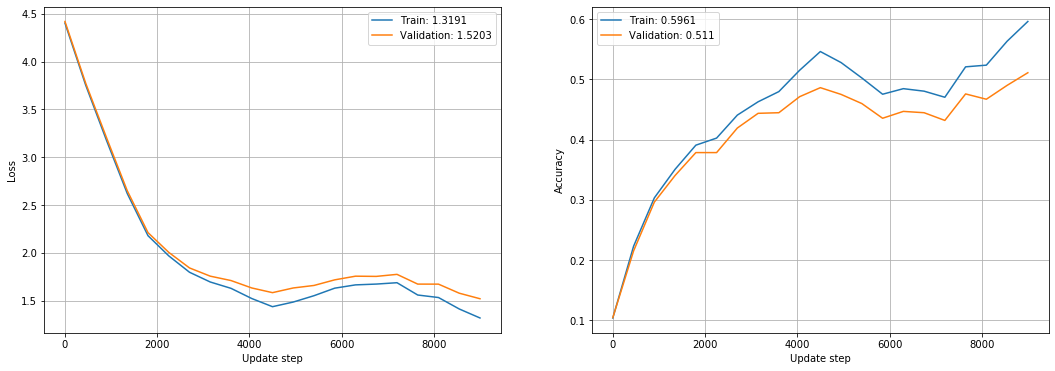

In [34]:
Plot(s_val, cycles=GDparams['cycles'])

## Sensitivity to initialization

In [105]:
hiddenDim = [50,50]
sigma = [1e-4, 1e-3, 1e-1]

for sig in sigma:
    
    for BN in [True, False]:
        W, b, gamma, beta = initializeValues(inDim, hiddenDim, outDim, he=False, std=sig)
        
        if BN:
            W, b, gamma, beta, me, v, s_val = MiniBatchGD(trainX, trianY, train_y, GDparams, 
                                              lamd, W, b, validX, validY, valid_y, gamma, beta, BN=True)
        else:
            me = None
            v == None
            gamma = None
            beta = None
            W, b, s_val = MiniBatchGD(trainX, trianY, train_y, GDparams, lamd, W, b, validX, validY, valid_y)
            
        acc = ComputeAccuracy(testX, test_y, W, b, BN, gamma, beta, me, v)
        s = 'Sigma: {} | Test Accuracy: {} | BN: {}'.format(sig, acc, BN)    
        print(s)

Sigma: 0.0001 | Test Accuracy: 0.5334 | BN: True0.61013333333333333
Sigma: 0.0001 | Test Accuracy: 0.1 | BN: Falsey=0.10041111111111112
Sigma: 0.001 | Test Accuracy: 0.5366 | BN: True=0.61397777777777777
Sigma: 0.001 | Test Accuracy: 0.1 | BN: Falsecy=0.10041111111111112
Sigma: 0.1 | Test Accuracy: 0.5339 | BN: Truecy=0.60831111111111115
Sigma: 0.1 | Test Accuracy: 0.5263 | BN: Falsey=0.56775555555555564
